## 2D Deconvolution on CUDA GPUs

In [2]:
using Revise, DeconvOptim, TestImages, Noise, CUDA, ImageShow, Colors, FFTW, Napari
FFTW.set_num_threads(4)
CUDA.allowscalar(false);

h_view(args...) = begin
    img = cat(args..., dims=2)
    img ./= maximum(img)
    Gray.(img)
end

h_view (generic function with 1 method)

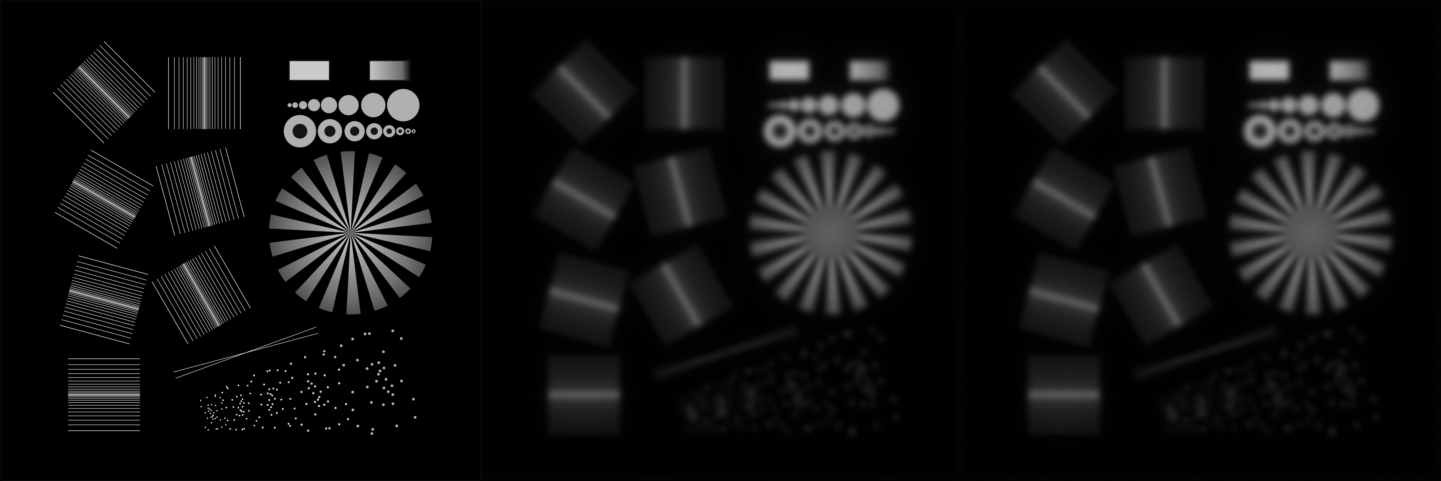

In [14]:
# load test images
img = Float32.(testimage("resolution_test_1920"))

psf = Float32.(generate_psf(size(img), 30))
psf_c = CuArray(psf)
# create a blurred, noisy version of that image
img_b = conv_psf(img, psf)
img_n = poisson(img_b, 300);

img_n_c = CuArray(img_n)
h_view(img, img_b, img_n)

In [4]:
reg = TV(mode="forward")

#150 (generic function with 1 method)

In [31]:
@time resG, optim_res = deconvolution(img_n, psf, loss=Poisson(), regularizer=reg, λ=0.005, iterations=20)

  5.227171 seconds (29.39 k allocations: 9.027 GiB, 5.75% gc time)


(Float32[0.040699996 0.04018969 … 0.037286375 0.037305005; 0.040098026 0.04003168 … 0.037511837 0.03710181; … ; 0.037716135 0.037458584 … 0.035958115 0.036269993; 0.037711713 0.037761252 … 0.036270157 0.04285803],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     7.374357e+05

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.10e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.69e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.56e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.83e-06 ≰ 0.0e+00
    |g(x)|                 = 4.08e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    20
    f(x) calls:    26
    ∇f(x) calls:   21
)

In [10]:
reg_gpu = TV_cuda()

TV_2D_view (generic function with 1 method)

In [30]:
CUDA.@time resG_c, optim_res_c = deconvolution(img_n_c, psf_c, loss=Poisson(), regularizer=reg_gpu, λ=0.005, iterations=20)

  0.339627 seconds (101.13 k CPU allocations: 4.456 MiB, 5.76% gc time) (1.97 k GPU allocations: 16.670 GiB, 8.00% gc time)


(Float32[0.040570665 0.040060442 … 0.037058942 0.037345007; 0.0401144 0.040075656 … 0.037227683 0.037127156; … ; 0.03770393 0.03753002 … 0.03603294 0.03630131; 0.03772762 0.037750956 … 0.036299974 0.04284748],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     7.374360e+05

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.82e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.44e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.31e+00 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.49e-06 ≰ 0.0e+00
    |g(x)|                 = 3.92e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    20
    f(x) calls:    26
    ∇f(x) calls:   21
)

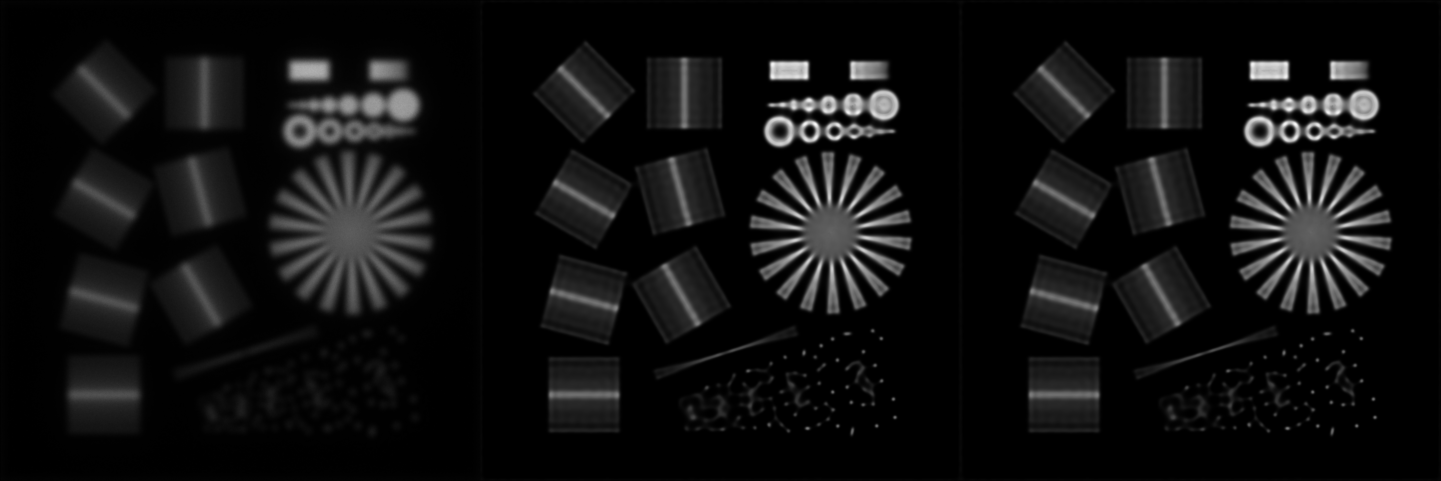

In [32]:
h_view(Array(img_n_c), Array(resG_c), Array(resG))

In [33]:
napari.view_image(Array(resG_c))
napari.view_image(Array(resG))
napari.view_image(Array(img_n))

PyObject <napari.viewer.Viewer object at 0x7fe7ecd05730>